In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean as cmo
import seaborn as sb

fpath = "/work/Katherine.Turner/tempest-extremes/ESM4"

def mask_composite(ds, var, start_year=0, min_lat=-90, max_lat=90, min_lon=0, max_lon=360):
    X = np.meshgrid(ds.x.data,ds.y.data)
    mask = xr.DataArray(np.sqrt(X[0]**2 + X[1]**2) <= 10, dims=['x', 'y'])
    
    idx_region = (ds.snap_time.dt.year > start_year) & (ds.snap_lat >= min_lat) & (ds.snap_lat <= max_lat) & \
    (ds.snap_lon >= min_lon) & (ds.snap_lon <= max_lon)
    
    test = ds[var][idx_region,:,:]
    test = xr.where(abs(test)>1e10, np.nan, test)
    test = xr.where(test==0, np.nan, test)

    out_masked = xr.where(mask, test, np.nan)
    return out_masked

In [2]:
ds_hfds = xr.open_dataset(f"{fpath}/hfds/comp_hfds_anom.nc", use_cftime=True)
#ds_massin = xr.open_mfdataset(f"{fpath}/comp_net_massin/comp_net_massin_anom.nc", use_cftime=True)
#ds_massout = xr.open_mfdataset(f"{fpath}/comp_net_massout/comp_net_massout_anom.nc", use_cftime=True)

ds_dic = xr.open_dataset(f"{fpath}/dic_stf_gas/comp_dic_stf_gas_anom.nc", use_cftime=True)
#ds_o2 = xr.open_dataset(f"{fpath}/comp_f_o2/comp_o2_stf_gas_anom.nc", use_cftime=True)

In [3]:
hfds_masked = mask_composite(ds_hfds, "snap_hfds_anom")
dic_masked = mask_composite(ds_dic, "snap_dic_stf_gas_anom")
#o2_masked = mask_composite(ds_o2, "snap_o2_stf_gas_anom")

In [4]:
X = np.meshgrid(ds_massin.x.data,ds_massin.y.data)
mask = xr.DataArray(np.sqrt(X[0]**2 + X[1]**2) <= 10, dims=['x', 'y'])

test = ds_massin.snap_net_massin_anom
test = xr.where(abs(test)>1e10, np.nan, test)
test = xr.where(test==0, np.nan, test)

massin_masked = xr.where(mask, test, np.nan)

test = ds_massout.snap_net_massout_anom
test = xr.where(abs(test)>1e10, np.nan, test)
test = xr.where(test==0, np.nan, test)

massout_masked = xr.where(mask, test, np.nan)

ds_mass_masked = massin_masked.mean(dim="snapshot").to_dataset(name="massin")
ds_mass_masked.update({"massout": massout_masked.mean(dim="snapshot")})

<xarray.Dataset>
Dimensions:  (x: 40, y: 40)
Coordinates:
  * x        (x) float64 -9.75 -9.25 -8.75 -8.25 -7.75 ... 8.25 8.75 9.25 9.75
  * y        (y) float64 -9.75 -9.25 -8.75 -8.25 -7.75 ... 8.25 8.75 9.25 9.75
Data variables:
    massin   (x, y) float32 dask.array<chunksize=(40, 40), meta=np.ndarray>
    massout  (x, y) float32 dask.array<chunksize=(40, 40), meta=np.ndarray>

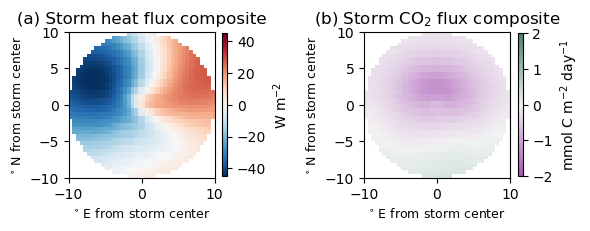

In [4]:
fig, axs = plt.subplots(figsize=(6,5.5), ncols=2, nrows=1)
axs=axs.flatten()

hfds_masked.mean(dim="snapshot").plot(ax=axs[0], y='y', cmap="RdBu_r",
                                     vmin=-45, vmax=45, extend="neither",
                                      cbar_kwargs = {'fraction': 0.03,
                                                    'aspect': 30,
                                                    'shrink': 0.7,
                                                    'label':'W m$^{-2}$'})


(1e3* 60**2 * 24 * dic_masked.mean(dim="snapshot")).plot(ax=axs[1], y='y', 
                                     cmap=sb.diverging_palette(300, 145, s=60, as_cmap=True),
                                     vmin=-2, vmax=2, extend="neither",
                                     cbar_kwargs = {'fraction': 0.03,
                                                    'aspect': 30,
                                                    'shrink': 0.7,
                                                    'label':'mmol C m$^{-2}$ day$^{-1}$'})


titles = ["(a) Storm heat flux composite", "(b) Storm CO$_2$ flux composite"]
for i in np.arange(2):
    axs[i].set_ylabel('$^{\circ}$ N from storm center', fontsize=9)
    axs[i].set_xlabel('$^{\circ}$ E from storm center', fontsize=9)
    axs[i].set_title(titles[i])
    axs[i].set_aspect(1)
    
plt.tight_layout()

plt.savefig("/work/Katherine.Turner/CM4_storms/analysis_figures/ESM4_storm_comp_flux_anom_2panel.png",
           format="png",
           dpi=100,
           bbox_inches="tight")
plt.savefig("/home/Katherine.Turner/Figures/tempest-extremes/composite_fluxes/ESM4_storm_comp_flux_anom_2panel.png",
           format="png",
           dpi=100,
           bbox_inches="tight")
plt.savefig("/home/Katherine.Turner/Figures/ESM4_storm_comp_flux_anom_2panel.eps",
           format="eps")

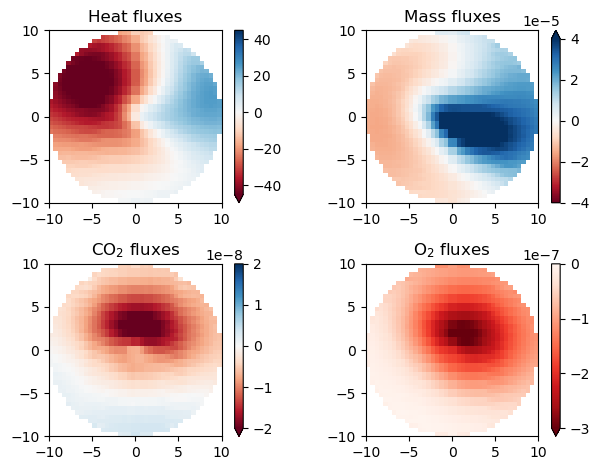

In [7]:
fig, axs = plt.subplots(ncols=2, nrows=2)
axs=axs.flatten()

hfds_masked.mean(dim="snapshot").plot(ax=axs[0], y='y', cmap="RdBu",
                                     vmin=-45, vmax=45)

(ds_mass_masked.massin + ds_mass_masked.massout).plot(ax= axs[1], y='y', cmap="RdBu", 
                                                     vmin=-4e-5, vmax=4e-5)

dic_masked.mean(dim="snapshot").plot(ax=axs[2], y='y', cmap="RdBu",
                                    vmin=-2e-8, vmax=2e-8)

o2_masked.mean(dim="snapshot").plot(ax=axs[3], y='y', cmap="Reds_r", vmin=-3e-7, vmax=0)


titles = ["Heat fluxes", "Mass fluxes", "CO$_2$ fluxes", "O$_2$ fluxes" ]
for i in np.arange(4):
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    axs[i].set_title(titles[i])
    axs[i].set_aspect(1)
    
plt.tight_layout()

plt.savefig("/work/Katherine.Turner/CM4_storms/analysis_figures/storm_comp_flux_anom.png",
           format="png",
           dpi=100,
           bbox_inches="tight")